Assignment 4: 

Name: Nisarg Upadhyay

UID: 118221625

Course: CMSC733

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: Nisarg

In [24]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from PIL import Image, ImageDraw
import os
import random
from sklearn.mixture import GaussianMixture

In [25]:
def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()



# Part 1: SLIC Superpixels (50 Points)

## Overview

Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential object contours, and thereby can replace the rigid pixel grid structure. Due to the reduced complexity, superpixels are becoming popular for various computer vision applications, e.g., multiclass object segmentation, depth estimation, human pose estimation, and object localization.

In this problem, you will implement a simple superpixel algorithm called Simple Linear Iterative Clustering (SLIC) that clusters pixels in the five-dimensional color and pixel coordinate space (e.g., r, g, b, x, y). The algorithm starts with a collection of K cluster centers initialized at an equally sampled regular grid on the image of N pixels. For each cluster, you define for a localized window 2S x 2S centered at the cluster center, where S = sqrt(N/K) is the roughly the space between the seed cluster centers. Then, you check whether the pixel within the 2S x 2S local window should be assigned to the cluster center or not (by comparing the distance in 5D space to the cluster center). Once you loop through all the clusters, you can update the cluster center by averaging over the cluster members. Iterate the pixel-to-cluster assignment process till convergence or maximum iterations reached.

Reference Paper: http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf

You can refer to the following slide covered in Lecture_17_Segmentation.pptx here: https://drive.google.com/file/d/1bRmNBXgK1_kWcY-nhw_As5fP10aRhuDC/view?usp=share_link






## Data
**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [3]:
# Download Data -- run this cell only one time per runtime
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
To: /content/Part1_SLIC.zip
100% 6.19M/6.19M [00:00<00:00, 38.9MB/s]
Archive:  /content/Part1_SLIC.zip
   creating: /content/Part1_SLIC/
  inflating: /content/Part1_SLIC/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/._.DS_Store  
   creating: /content/Part1_SLIC/sample_data/
   creating: /content/Part1_SLIC/BSD_data/
  inflating: /content/Part1_SLIC/sample_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._.DS_Store  
   creating: /content/Part1_SLIC/sample_data/images/
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._images  
   creating: /content/Part1_SLIC/sample_data/groundTruth/
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._groundTruth  
  inflating: /content/Part1_SLIC/BSD_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/BSD_data/._.DS_Store  
   creating: /content/Part1_SLIC/BSD_data/images/
   creating: /content/Part1_SLIC/BSD_data/groun

## Helper Functions:

### Code (15 pts)

In [31]:
# A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixels(object):

    def __init__(self, h, w, l=0, a=0, b=0):
        self.update(h, w, l, a, b)
        self.pixels = []

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

# function which returns an object of class SuperPixel
def make_superPixel(h, w,img):
    return SuperPixels(h, w,img[h,w][0],img[h,w][1],img[h,w][2])

def display_clusters(img, clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    rgb_arr = color.lab2rgb(image) 
    show_image(rgb_arr)


In [102]:
# Functions for Simple Linear Iterative Clustering (SLIC)
def initialize_cluster_centers(S,img,img_h,img_w,clusters):
    #### Write your code here ####
    # To Do: Initialize "clusters" by sampling pixels at an equally sampled regular grid (distanced by S)
    # on the image of N pixels. N = img_h X img_w. Hint: clusters.append(make_superPixel(h, w, image)) to create each cluster/super-pixel.
    h = S // 2
    w = S // 2
    while h < img_h:
        while w < img_w:
            clusters.append(make_superPixel(h, w,img))
            w += S
        w = S // 2
        h += S
    return clusters

# function to calculate gradient at each pixel 
# function to calculate gradient at each pixel 
def calc_gradient(h, w,img,img_w,img_h):
    if w + 1 >= img_w:
        w = img_w - 2
    if h + 1 >= img_h:
        h = img_h - 2

    grad = np.linalg.norm(img[h + 1, w + 1][0] - img[h, w][0]) +  np.linalg.norm(img[h + 1, w + 1][1] - img[h, w][1]) +  np.linalg.norm(img[h + 1, w + 1][2] - img[h, w][2])
    return grad

def relocate_cluster_center_at_lowgrad(clusters,img,img_w,img_h):
    #### Write your code here ####
    # To Do:
    # for each cluster c, reassign cluster to the pixel having smallest gradient value.
    # Step 1: compute gradient wrt cluster-center c.h, c.w in 3X3 neighborhood of cluster center.
    # Step 2: Similarly, compute gradient for each pixel in 3X3 spatial neighborhood of cluster c.
    # Step 3. Reassign cluster-center to the pixel (x,y) having the lowest gradient. 
    # Hint: c.update(img[x,y][0], img[h,w][1], img[x,y][2], x, y)
    for c in clusters:
        cluster_gradient = calc_gradient(c.h, c.w,img,img_w,img_h)
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                H = c.h + dh
                W = c.w + dw
                new_gradient = calc_gradient(H,W, img,img_w,img_h)
                if new_gradient < cluster_gradient:
                    c.update(H, W,img[H-1,W][0], img[H-1,W][1],img[H-1,W][2])
                    c_gradient = new_gradient

def assign_cluster(clusters,S,img,img_h,img_w,tag,dis,m):
    #### Write your code here ####
    # To Do: Compare each pixel to cluster center within 2S pixel distance and assign to nearest cluster using the "distance metric"
    # (involving both color and spatial dimensions of pixel and cluster, 
    # Hints: 
    # 1. use "dis" matrix for comparing distances.
    # 2. You can use c.pixels.append((h, w)) to keep track of cluster-assignments.
    for c in clusters:
        for h in range(c.h - 2 * S, c.h + 2 * S):
            if h < 0 or h >= img_h: continue
            for w in range(c.w - 2 * S, c.w + 2 * S):
                if w < 0 or w >= img_w: continue
                l, a, b = img[h,w]
                Dc = math.sqrt(math.pow(l - c.l, 2) + math.pow(a - c.a, 2) + math.pow(b - c.b, 2))
                Ds = math.sqrt(math.pow(h - c.h, 2) + math.pow(w - c.w, 2))
                D = math.sqrt(math.pow(Dc / m, 2) + math.pow(Ds /S, 2))
                if D < dis[h,w]:
                    if (h, w) not in tag:
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        tag[(h, w)].pixels.remove((h, w))
                        tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D
    return None

def update_clusters(clusters,image):
    #### Write your code here ####
    # To Do: For each cluster, update the cluster center with mean of the pixels assigned (c.pixels)
    for c in clusters:
        sum_h = sum_w = number = 0
        #print("c.pixels",c.pixels)
        for p in c.pixels:
            sum_h += p[0]
            sum_w += p[1]
            number += 1
            H = sum_h // number
            W = sum_w // number
            c.update(H, W,image[H, W][0], image[H, W][1], image[H, W][2])

def compute_res_error(old_clusters, new_clusters):
    #### Write your code here ####
    #### Write your code here ####
    total_error = 0.0
    # error = Compute L1 distance between previous cluster-centres and new cluster centers.
    for (o,n) in zip( old_clusters,new_clusters):
      old_h = o.h
      old_w = o.w
      new_h = n.h
      new_w = n.w
      old_loc = [old_h,old_w]
      new_loc = [new_h,new_w]
      old_loc = np.array(old_loc)
      new_loc = np.array(new_loc)
      error = np.linalg.norm(old_loc- new_loc)

      total_error = total_error+error
    return total_error

def slic_algorithm(S, image, img_h, img_w, clusters, tag, dis,m):

    # Initialize cluster centers on pixel grid in steps S
    clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)

    # Move centers to position in 3x3 window with smallest gradient.
    relocate_cluster_center_at_lowgrad(clusters, image, img_w, img_h)

    # You can play around with these hyper-params.
    res_err = 123456789.0 # init residual_error with a very large value (choose as per your understanding.)
    threshold = 0.01 # tune this

    while(res_err >= threshold):

      assign_cluster(clusters, S, image, img_h, img_w, tag, dis,m)
      old_clusters = copy.deepcopy(clusters)
      update_clusters(clusters,image)

      res_err = compute_res_error(old_clusters, clusters)
      if res_err < threshold:
        break
    
    return clusters    


In [103]:
# Main Block:

img_path = "/content/Part1_SLIC/BSD_data/images/10081.jpg"

# Load image and convert it from an unsigned 8-bit integer to a floating point data type.
image = (io.imread(img_path))

# convert RGB to LAB
image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

# k: Number of clusters/superpixels.
k = 64
N = img_h * img_w  # Total pixels in the image
S = int(math.sqrt(N /k)) # Average size of each superpixel
m = 20

clusters = []
cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.
start = time.time()

clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,m)


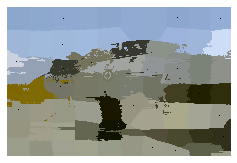

In [70]:
display_clusters(image, clusters)

### Write-up (35 pts)
* a) [5 points] Explain your distance function for measuring the similarity between a pixel and cluster in the 5D space.
* b) [5 points] Choose one image, try three different weights on the color and spatial feature and show the three segmentation results. Describe what you observe.
* c) [5 points] Choose one image, show the error (1) at the initialization and (2) at convergence. Note: error - distance to cluster center in the 5D space.
* d) [10 points] Choose one image and show three superpixel results with different number of K, e.g., 64, 256, 1024 and run time for each K.
* e)  [10 points] Run your algorithms on the subset (50 images) of Berkeley Segmentation Dataset (BSD) with K = 64, 256 and 1024 and report averaged run-time per image for the BSD.


## **Answer A**
In our case the 5D Space is denoted as lab according to the LAB color space and the x and y coordinates of the pixel that represnts the location.
So for every pixel we will have 5 variables in order [l,a,b,x,y]

Now to find the distance between the clsuter center and the pixel is divided into 2 parts

Distance based on l,a,b which will be euclidian distance between cluster center and the pixel, that will be.
**D(lab) = sqrt((l - c.l, 2)^2 + (a - c.a, 2)^2 + (b - c.b, 2)^2)**

Distance based on x an y will be euclidian distance between cluster center and the pixel, that will be. 
**D(xy) = sqrt((y - c.y, 2)^2 + (x - c.x, 2)^2)**

then to find the distance between the 
**D = sqrt((Dc / m, 2)^2 + (Ds /S, 2)^2)**
here m is a constant we assume to be 20 and S is the distance between centers.

Finally we will create distance array which will keep track of all the distance of the pixels. Then for ervery pixel we will find the dinstance compare it with the distance array and according to it we will append or remove the pixels form the tag dictonary.

## ANSWER B



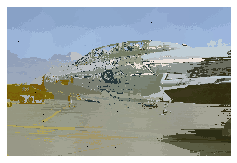

In [73]:
display_clusters(image, clusters)

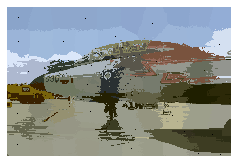

In [76]:
display_clusters(image, clusters)

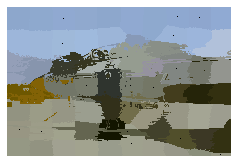

In [78]:
display_clusters(image, clusters)

Above are the 3 results of different weights in increasing order.
As it was noticed that as weight increase computation time deacreases.
As weights gets increasing the the error distance also increases as weight is direclty propotional to the due to which the quality of super pixels increases as we increase the weight. 


## Answer C

In [90]:
# Main Block:

img_path = "/content/Part1_SLIC/BSD_data/images/10081.jpg"

# Load image and convert it from an unsigned 8-bit integer to a floating point data type.
image = (io.imread(img_path))

# convert RGB to LAB
image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

# k: Number of clusters/superpixels.
k = 64
N = img_h * img_w  # Total pixels in the image
S = int(math.sqrt(N /k)) # Average size of each superpixel
m = 20

clusters = []
cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,m)

566.6113526715488
240.81767814481066
82.82334851703335
70.83943907921672
41.57276553499814
12.23606797749979
4.0
1.0
1.0
0.0


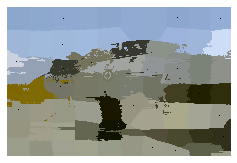

In [91]:
display_clusters(image, clusters)

Above are the result of the total error that we get after each iterations.

## Answer D

Below are the result of same image that segnemented with 64,256,1024 superpixels and time taken to complete them in second.

143.84261918067932


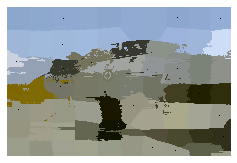

In [94]:

display_clusters(image, clusters)

161.437180519104


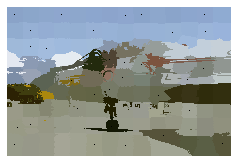

In [96]:

display_clusters(image, clusters)

73.52444744110107


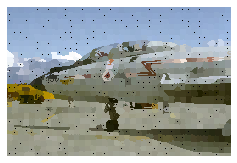

In [98]:

display_clusters(image, clusters)

## Answer E

Below are the 5 random images with 64 super pixels and there average time

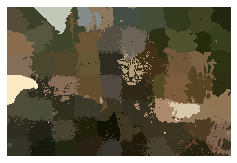

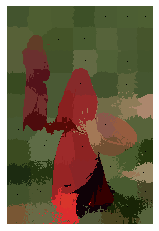

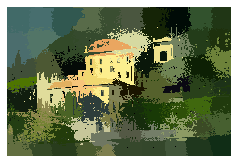

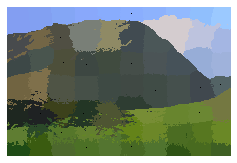

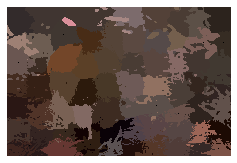

151.69721097946166


In [104]:
# Main Block:
def slic_image_show(image_path, K = 64):
    
    rgb = io.imread(image_path,plugin='matplotlib')
    # Load image and convert it from an unsigned 8-bit integer to a floating point data type.
    #image = img_as_float(io.imread(img_path))

    # convert RGB to LAB
    image = color.rgb2lab(rgb)
    img_h = image.shape[0] #  Height
    img_w = image.shape[1] #  Width

    # k: Number of clusters/superpixels.
    # k: Number of clusters/superpixels.
    k = K
    m = 20
    N = img_h * img_w  # Total number of pixels in the image
    S = int(math.sqrt(N /k)) # average size of each superpixel

    clusters = []
    cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
    dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.
    start = time.time()
    clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,m)
    end = time.time()
    time_taken = end - start
    display_clusters(image, clusters)
    
    return time_taken

def slic_all(K = 64, num_img = 2):
    IMAGE_FOLDER = '/content/Part1_SLIC/BSD_data/images/'

    filename = random.choice(os.listdir(IMAGE_FOLDER))
    path = '%s/%s' % (IMAGE_FOLDER , filename)
    all_time = []
    T = 0
    for i in range(num_img):
        filename = random.choice(os.listdir(IMAGE_FOLDER))
        path = '%s/%s' % (IMAGE_FOLDER , filename)
        t = slic_image_show(path, K = 64)
        T = T + t
    T = T/num_img
    return T

avg_time = slic_all(64,5)
print(avg_time)

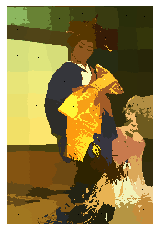

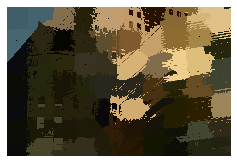

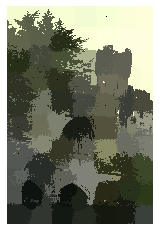

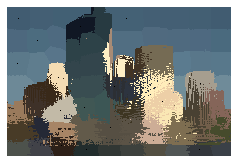

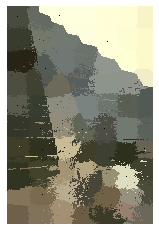

173.09683160781861


In [105]:
avg_time = slic_all(128,5)
print(avg_time)

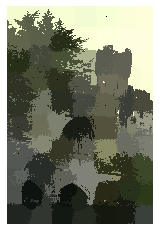

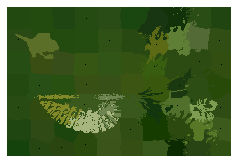

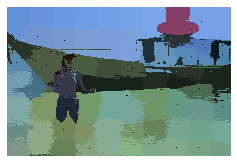

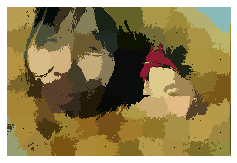

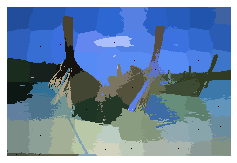

157.61635584831237


In [106]:
avg_time = slic_all(1024,5)
print(avg_time)

### Extra Credit (20 pts)
* f) [upto 10 points] Implement and report two types of metrics (1) boundary recall and (2) under-segmentation error with K = 64, 256 and 1024 on the BSD (last part of write-up).
* g) [upto 10 points] Try to improve your result from first part of extra-credit. You may try different color space (e.g., CIELab, HSV) (See Sec 4.5 in the paper), richer image features (e.g., gradients) or any other ideas you come up with. Report the accuracy on boundary recall and under-segmentation error with K = 256. Compare the results with first-part of extra-credit and explain why you get better results.

### Hints 
- For main part, you CAN NOT use any library such as skimage / cv2 to perform or implement SLIC segmentation.
- For better visualization, you may use external function (skimage.segmentation.mark_boundaries) for your purpose.
- For EXTRA CREDIT part, you are allowed to use external library for metrics (boundary recall and under-segmentation error)

# Part 2: Graph-cut Segmentation (50 points)

## Overview

Let us apply Graph-cuts for foreground/background segmentation. In the “cat” image, you are given a rough polygon of a foreground cat. Apply graph-cut based method to see if we can get a better segmentation!

Firstly, use the provided polygon to obtain an estimate of foreground and background color likelihood. You may choose the likelihood distribution (e.g., color histograms or color mixture of Gaussians.).

Secondly, apply graph-cut code (cv2.grabcut) to do better segmentation. You can use the provided bounding-boxes and use "cv2 package" for the implementation sake. You are required to draw interesting conclusions on how it performs on different samples.

## Data 

In [107]:
# Download Data -- run this cell only one time per runtime
# !gdown 1ObpNoshjKMcB7SFvrTuoKe61IE-HG95n
!gdown 1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
!unzip "/content/Part2_GraphCut.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
To: /content/Part2_GraphCut.zip
100% 264k/264k [00:00<00:00, 98.9MB/s]
Archive:  /content/Part2_GraphCut.zip
   creating: /content/Part2_GraphCut/
  inflating: /content/Part2_GraphCut/dog.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._dog.jpg  
  inflating: /content/Part2_GraphCut/messi.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._messi.jpg  
  inflating: /content/Part2_GraphCut/.DS_Store  
  inflating: /content/__MACOSX/Part2_GraphCut/._.DS_Store  
  inflating: /content/Part2_GraphCut/plane.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._plane.jpg  
  inflating: /content/Part2_GraphCut/bird.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._bird.jpg  
  inflating: /content/Part2_GraphCut/cat.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._cat.jpg  
  inflating: /content/Part2_GraphCut/cat_poly.mat  
  inflating: /content/__MACOSX/Part2_GraphCut/._cat_poly.mat  


## Helper Functions

#### Code (15 pts)

In [108]:

def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

# Get a normalized version of the given histograms (divide by sum)
def normalize_histograms(histograms):
  return np.float32([h / h.sum() for h in histograms])


In [109]:
def mask_for_fg(img, img_mask):
  # Write code here 
  # to generate foreground region (and everything else masked out).
  pixels = np.argwhere(img_mask == True)
  fg_image = np.zeros((img.shape),dtype = np.uint8) 
  for i in pixels:
    intensity = np.array(img[i[0],i[1],:])
    fg_image[i[0],i[1],:] = intensity
  return fg_image

def mask_for_bg(img, img_mask):
  # Write code here
  # generate background region (and everything else masked out).
  pixels = np.argwhere(img_mask == False)
  bg_image = np.zeros((img.shape),dtype = np.uint8) 
  for i in pixels:
    intensity = np.array(img[i[0],i[1],:])
    bg_image[i[0],i[1],:] = intensity
  return bg_image


def gaussian_model(img):
  # Write your code here.
  # fit gaussian model on a given image.

  dataPoints = np.reshape(img,(-1,3))
  gmm_model = GaussianMixture(n_components=2,random_state=0).fit(dataPoints) 
  gmm_labels = gmm_model.predict(dataPoints)

  return gmm_model, gmm_labels


def visualize_likelihood_map(gmm_bg, gmm_fg, img):
  dataPoints = np.reshape(img,[-1,3])

  # calculate fg likelihood
  fg_likelihood= gmm_fg.score_samples(dataPoints)
  likelihood_map_fg = -1* np.reshape(fg_likelihood,(img.shape[0],img.shape[1]))

  # calculate bg likelihood
  bg_likelihood= gmm_bg.score_samples(dataPoints)
  likelihood_map_bg = -1* np.reshape(bg_likelihood,(img.shape[0],img.shape[1]))
  
  show_image(likelihood_map_bg,2.0)
  show_image(likelihood_map_fg,2.0)
 
 
  return None

def run_grabcut(img, bbox, itercount = 10):
  # Write your code here.
  # You can use opencv cv2.grabCut algorithm with "cv2.GC_INIT_WITH_RECT" to implement this.
  mask = np.zeros(img.shape[:2],np.uint8)

  bgModel = np.zeros((1,65), np.float64)
  fgModel = np.zeros((1,65), np.float64) 
  mask, bgModel, fgModel = cv2.grabCut(img, mask, bbox, bgModel, fgModel, itercount, cv2.GC_INIT_WITH_RECT)
  grabcut_mask  = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD),0, 1)
  grabcut_mask  = (grabcut_mask  * 255).astype("uint8")
  return (grabcut_mask, bgModel, fgModel)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


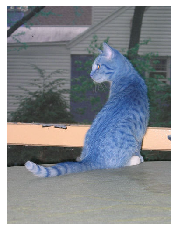

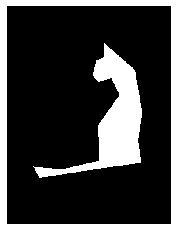

In [110]:
### Main Block: ###

# read image
img_name = 'cat'
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

# read image_mask
poly = scipy.io.loadmat('/content/Part2_GraphCut/cat_poly.mat')['poly']
img_mask = poly2mask(poly[:,1], poly[:,0], (img.shape[0],img.shape[1]))

show_image(img)
show_image(img_mask)

In [111]:
# 1. Fit Gaussian mixture model for foreground regions.

# Generate image (fg_image) with background masked using img_mask
fg_image = mask_for_fg(img, img_mask)
gmm_fg, fg_gmm_labels = gaussian_model(fg_image)


# 2. Fit Gaussian mixture model for background regions.
# Generate image (fg_image) with foreground masked using img_mask
bg_image = mask_for_bg(img, img_mask)
gmm_bg, bg_gmm_labels = gaussian_model(bg_image)

## Answer A) 
The GMM_score method is used to make a prediction as to whether each pixel is either a foreground or background pixel, based on fg_model and a bg_model. The visualize_likelihood function is used to calculate and illustrate the chance that a pixel is either a foreground or background color.

## Answer B)
Below are the results of the visualization map.
Displayed as P(foreground|pixel) as an intensity map (bright = confident foreground).

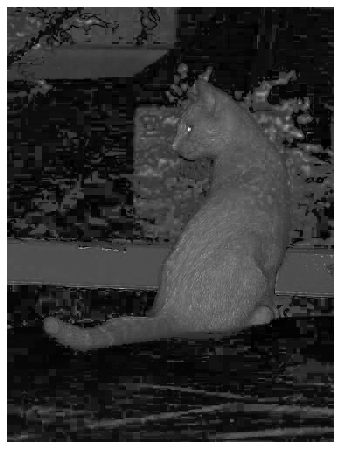

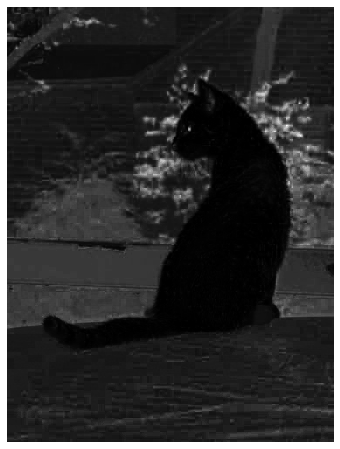

In [112]:
# 3. Compute and visualize the foreground cost and background cost as an image.
# Foreground label cost: -log Pr[Image | foreground model]
# Foreground label cost: -log Pr[Image | background model]

visualize_likelihood_map(gmm_bg, gmm_fg, img)


## Answer C

Grabcut is able to segment the fg in a smaller number of iterations if the rectangular bounding box has all the pixels which can specify the all the characteristics of the fireground image.

In the case of difficult segmentation, the grabcut algorithm can not properly distinguish between the foreground and the background

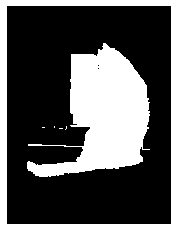

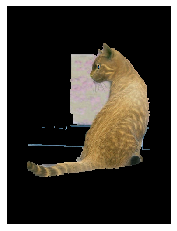

In [114]:
# 4. Run grabcut algorithm.
bboxes = {'cat':(45,80,285,320), 'dog':(330,60,310,570), 'plane': (40,180,835,250), 'messi':(70,5,600,445), 'bird':(100,100,350,250)}

img_name = 'cat'
bbox = bboxes[img_name]
img_path = '/content/Part2_GraphCut/cat.jpg'
image = cv2.imread(img_path)


(grabcut_mask, bgModel, fgModel) = run_grabcut(image, bbox)
show_image(grabcut_mask)
masked_img = image*grabcut_mask[:,:,np.newaxis]
show_image(masked_img)

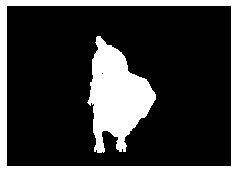

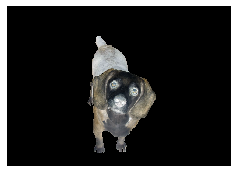

In [115]:
img_name = 'dog'
bbox = bboxes[img_name]
img_path = '/content/Part2_GraphCut/dog.jpg'
image = cv2.imread(img_path)


(grabcut_mask, bgModel, fgModel) = run_grabcut(image, bbox)
show_image(grabcut_mask)
masked_img = image*grabcut_mask[:,:,np.newaxis]
show_image(masked_img)

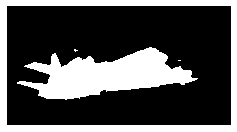

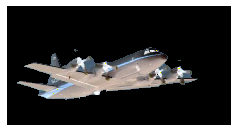

In [116]:
img_name = 'plane'
bbox = bboxes[img_name]
img_path = '/content/Part2_GraphCut/plane.jpg'
image = cv2.imread(img_path)


(grabcut_mask, bgModel, fgModel) = run_grabcut(image, bbox)
show_image(grabcut_mask)
masked_img = image*grabcut_mask[:,:,np.newaxis]
show_image(masked_img)

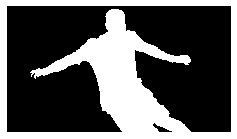

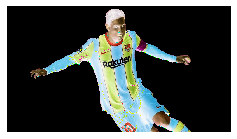

In [118]:
img_name = 'messi'
bbox = bboxes[img_name]
img_path = '/content/Part2_GraphCut/messi.jpg'
image = cv2.imread(img_path)


(grabcut_mask, bgModel, fgModel) = run_grabcut(image, bbox)
show_image(grabcut_mask)
masked_img = image*grabcut_mask[:,:,np.newaxis]
show_image(masked_img)

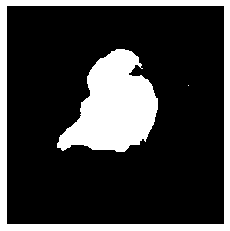

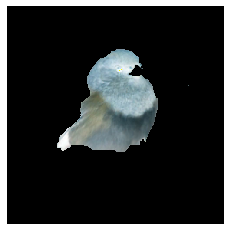

In [120]:
img_name = 'bird'
bbox = bboxes[img_name]
img_path = '/content/Part2_GraphCut/bird.jpg'
image = cv2.imread(img_path)


(grabcut_mask, bgModel, fgModel) = run_grabcut(image, bbox)
show_image(grabcut_mask)
masked_img = image*grabcut_mask[:,:,np.newaxis]
show_image(masked_img)

## Answer D)
Grabcut wih different iterrations 1,7, 13

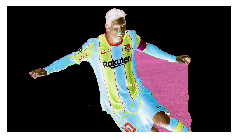

In [122]:
img_name = 'messi'
bbox = bboxes[img_name]
img_path = '/content/Part2_GraphCut/messi.jpg'
image = cv2.imread(img_path)


(grabcut_mask, bgModel, fgModel) = run_grabcut(image, bbox,1)
masked_img = image*grabcut_mask[:,:,np.newaxis]
show_image(masked_img)

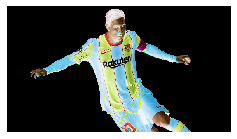

In [123]:
img_name = 'messi'
bbox = bboxes[img_name]
img_path = '/content/Part2_GraphCut/messi.jpg'
image = cv2.imread(img_path)


(grabcut_mask, bgModel, fgModel) = run_grabcut(image, bbox,7)
masked_img = image*grabcut_mask[:,:,np.newaxis]
show_image(masked_img)

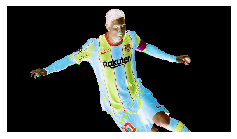

In [124]:
img_name = 'messi'
bbox = bboxes[img_name]
img_path = '/content/Part2_GraphCut/messi.jpg'
image = cv2.imread(img_path)


(grabcut_mask, bgModel, fgModel) = run_grabcut(image, bbox,13)
masked_img = image*grabcut_mask[:,:,np.newaxis]
show_image(masked_img)

It is obvious from the images presented above of the messi that the algorithm performed better by segmenting between fg and bg as the number of iterations increased.


### Write-up (35 points)

- a) [5 points] Explain your foreground and background likelihood function.
- b) [10 points] Your foreground and background likelihood map. 

Display P(foreground|pixel) as an intensity map (bright = confident foreground).
- c) [15 points] Implement grabcut segmentation using cv2 package and draw insights on how the segmentation performs on different sample images (hard v/s easy).
- d) [5 points] Try grabcut algorithm with different "iterCount" to see if results improve in certain cases.

### Hints 
- You may refer to https://docs.opencv.org/4.x/dd/dfc/tutorial_js_grabcut.html to implement run_grabcut()